# Mobile Case Category Classification using Logistic Regression

Using machine learning and image recognition, the task is to classify mobile case images into one of the 16 different categories. The data is part of the competition at - <https://www.crowdanalytix.com/contests/identifying-themes-from-mobile-case-images>. The categories have been defined for the training data and categories for the test data set have been kept anonymous.

Here, we implement a simple multilayer perceptron in order to see how PCA+Logistic Regression on this particular dataset performs. It is also an attempt to generalize the process of analysing data using neural networks and understanding the performance of neural networks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.transform import rescale
from skimage.color import rgb2gray
from scipy.misc import imresize

import matplotlib.pyplot as plt
%matplotlib inline

import os
os.chdir("D:/Ubuntu/CreditCardFraud/")

import glob
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, ShuffleSplit, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.decomposition import PCA, IncrementalPCA

## Read training data

Since test data categories are anonymized, lets focus on training data and robust cross validation strategy to develop our model.

In [2]:
img_folders = [x[0] for x in os.walk("./data/Train/")]
h, w = 64, 64 # resized image dimensions
train_img = []
label = []
img_id = []

for fldr in img_folders[1:]:
    img_list = glob.glob(fldr + '/*.jpg')
    for img in img_list:
        bw_img = rgb2gray(mpimg.imread(img))
        # Keep rows and columns of the actual image
        bw_img = np.delete(bw_img, np.where((np.std(bw_img,axis=0)>0.05)==False), axis=1)
        bw_img = np.delete(bw_img, np.where((np.std(bw_img,axis=1)>0.05)==False), axis=0)
        if bw_img.shape[0]>=h and bw_img.shape[1]>=w:
            bw_img_resize = imresize(bw_img, (h,w))
            train_img.append(imresize(bw_img,(h,w)))
            label.append(fldr[13:])
            img_id.append(img)
train_img = np.stack(train_img, axis=0)

# Encode labels as 0-15
le = LabelEncoder()
train_label = le.fit_transform(label)

C:\Users\Raunak Mundada\AppData\Local\conda\conda\envs\DeepLearning\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Users\Raunak Mundada\AppData\Local\conda\conda\envs\DeepLearning\lib\site-packages\numpy\core\_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Raunak Mundada\AppData\Local\conda\conda\envs\DeepLearning\lib\site-packages\numpy\core\_methods.py:114: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\Raunak Mundada\AppData\Local\conda\conda\envs\DeepLearning\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in greater


In [3]:
# Flat array
train_img_flat = train_img.reshape(train_img.shape[0],-1)

print ("Total Images: ",len(train_img))
print("Total features: ", train_img_flat.shape[1])
print("Classes: ", len(np.unique(label)))

Total Images:  4570
Total features:  4096
Classes:  16


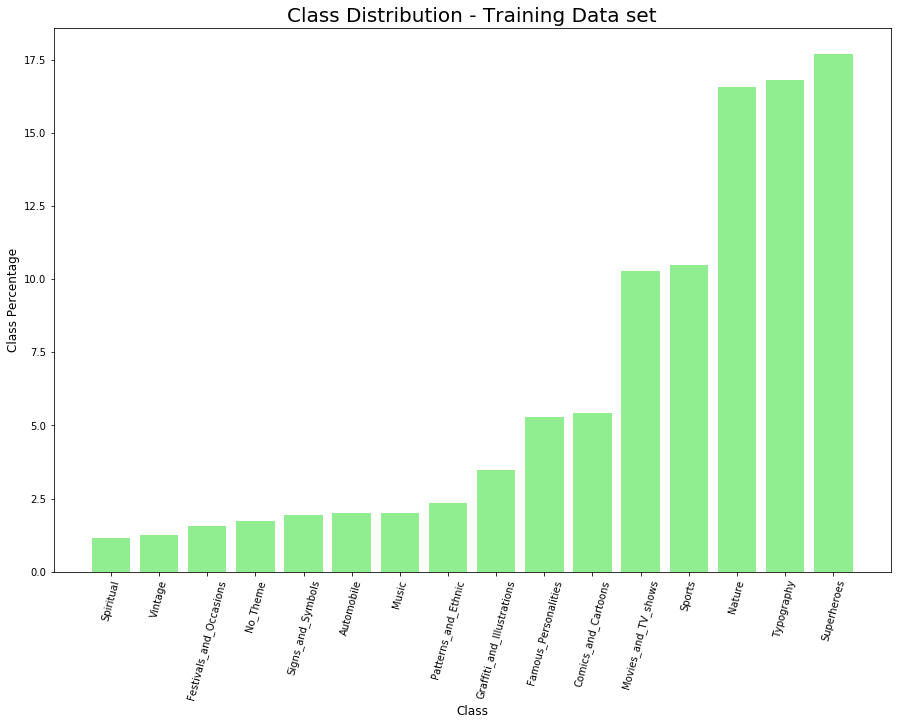

In [4]:
# Class distribution
class_dict = Counter(label)
plt.figure(figsize=(15,10))
plt.bar(range(len(class_dict)), 
        sorted(np.array(list(class_dict.values()), dtype='int64')*100/len(train_img)), 
        align='center', color='lightgreen')
plt.xlabel("Class", fontsize=12)
plt.xticks(range(len(class_dict)),class_dict.keys(), rotation=75)
plt.ylabel("Class Percentage",fontsize=12)
plt.title("Class Distribution - Training Data set", fontsize=20)

As we can see, the classes are highly imbalanced. We have to keep this in mind when evaluating model performance. An appropriate metric in this case would be an f1-score (weighted average by number of true instances for each class), taking into account the class imbalance.

F1-score is defined as follows - 

Let,
* K = number of class
* TP = True Positives

Then we can define precision and recall for each class *k* as,
$$ Precision = \frac {\sum(TP_c)}{\sum{PositivePredictions}} $$

$$ Recall = \frac {\sum(TP_c)}{\sum{PositiveInstances}} $$

Therefore we define the f1-score for class *k* which is just the harmonic mean of precision and recall for class *k* as,

$$ f1_k = 2*\frac {precision * recall}{precision + recall} $$

Then the weighted (weights are defined as the total number of instances for each class) average of f1-scores for all classes is given by 

$$ F1_{weighted} = \frac {\sum_{k=1}^{K} {w_k*f1_k}}{\sum_{k=1}^{K} w} $$

where $w_k$ is the total number of instances for class *k*

In [5]:
def plot_gallery(imgs):
    np.random.seed(1)
    plt.figure(figsize=(25,25))
    
    for k in range(25):
        randInd = np.random.randint(np.shape(imgs)[2])
        plt.subplot(5,5,k+1); 
        plt.imshow(imgs[randInd,:,:], cmap='gray'); plt.axis('off')
        plt.title('imageID = ' + str(randInd), fontsize=20)
    plt.tight_layout()

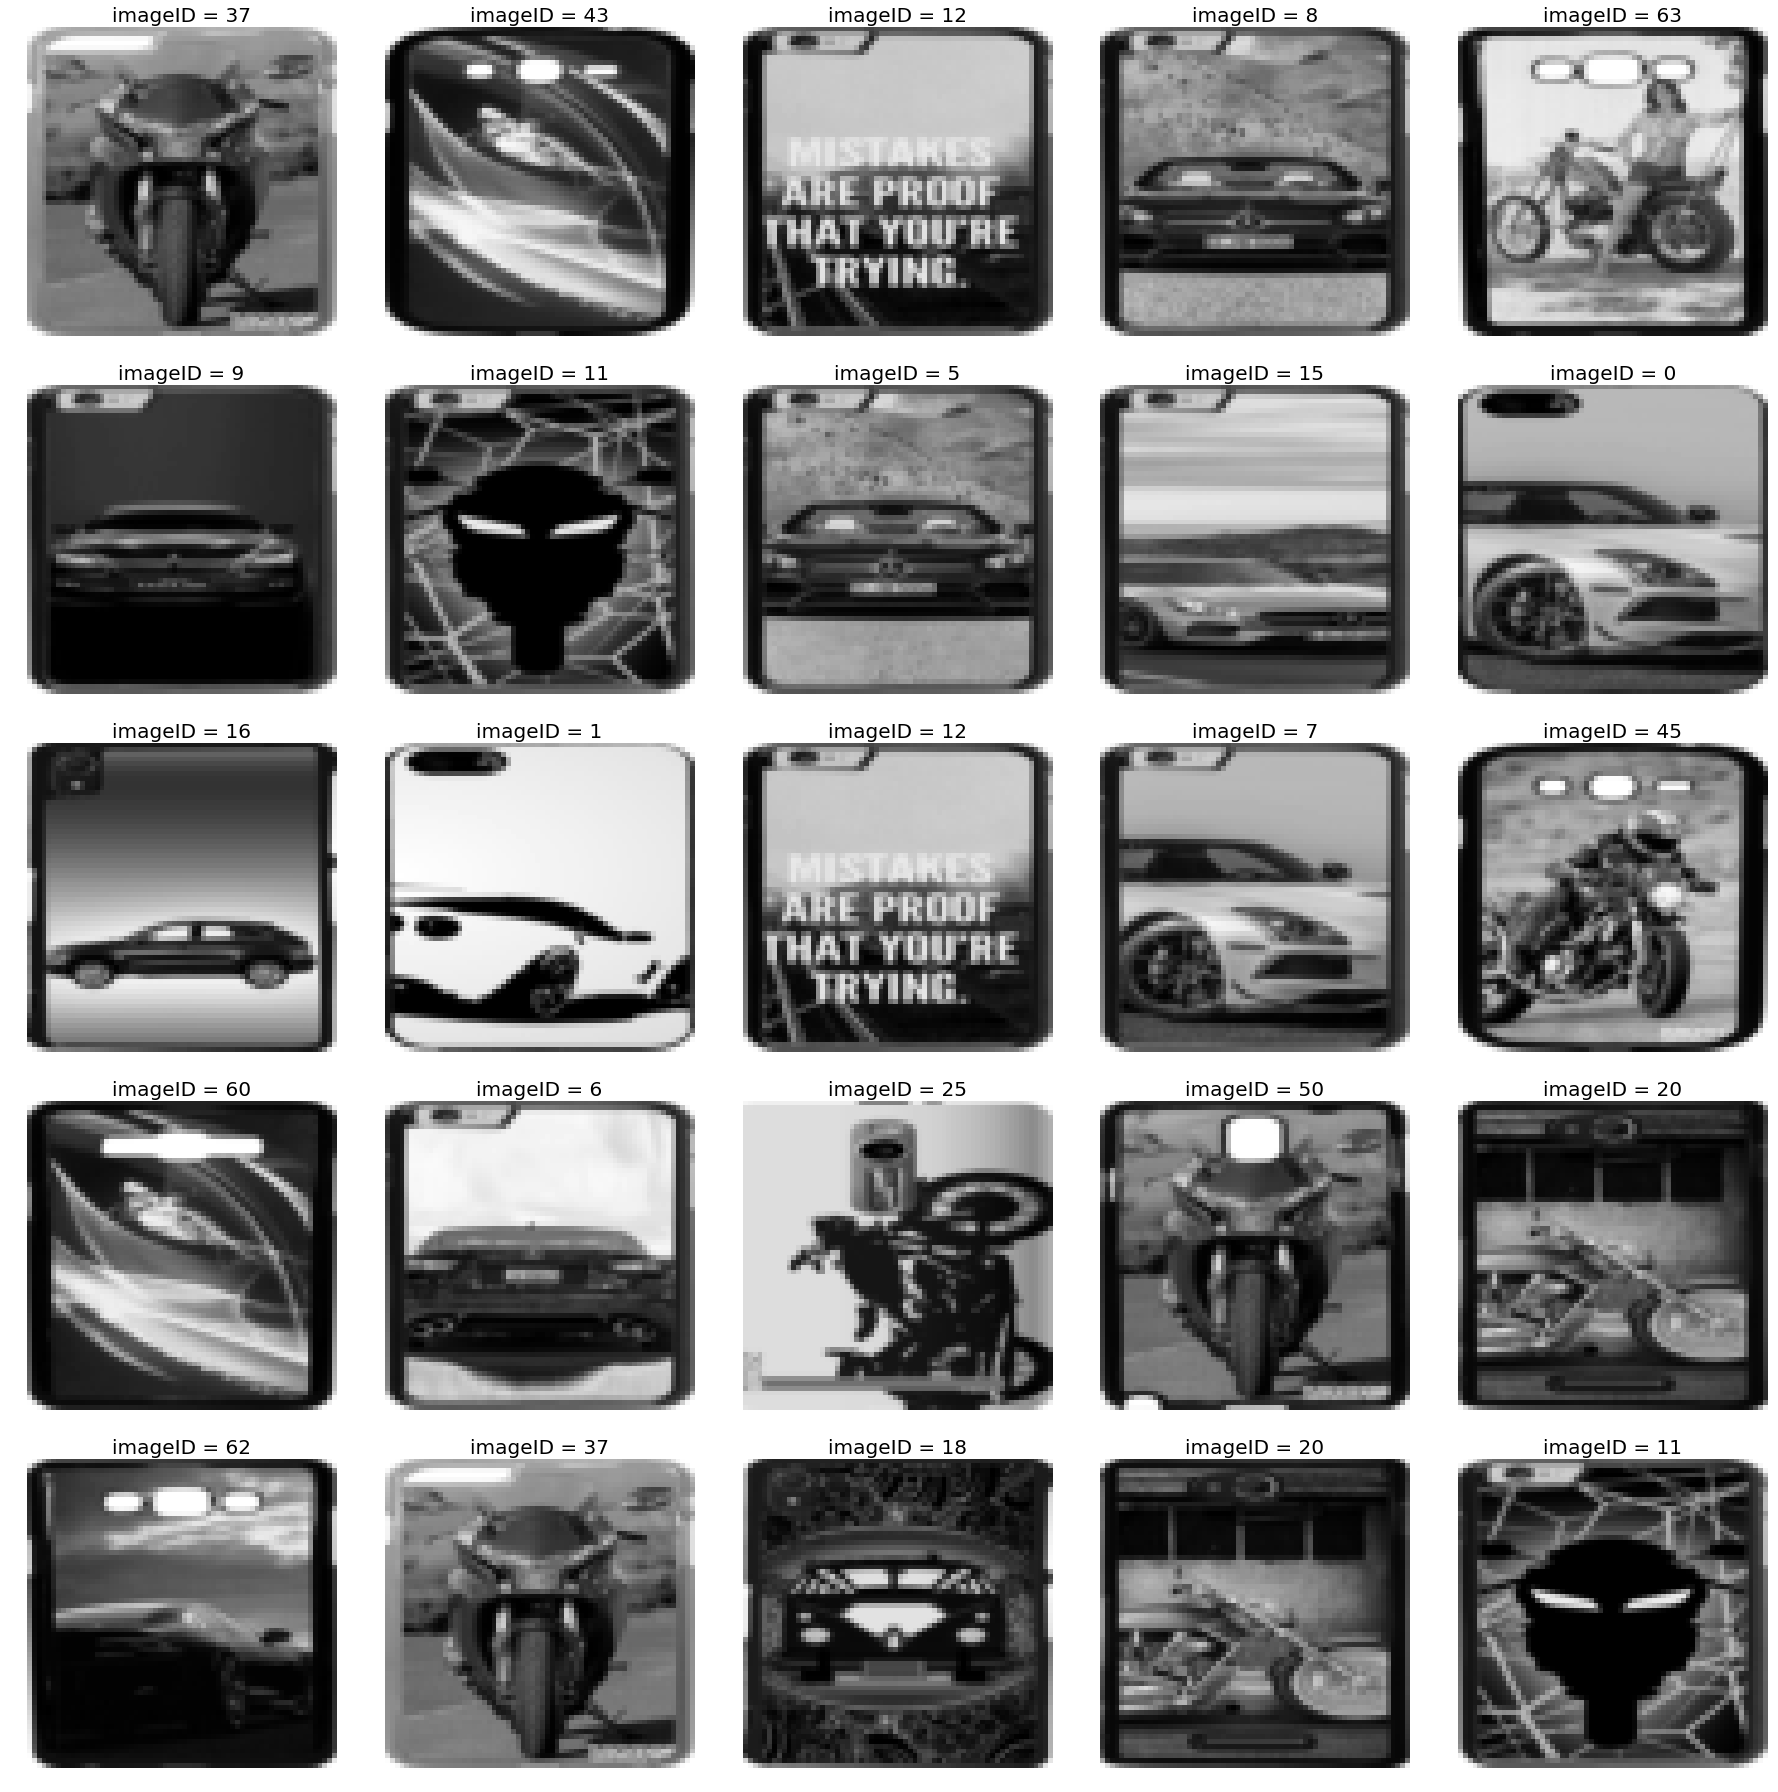

In [6]:
plot_gallery(train_img)

## Analyze images using PCA

The following function computes the optimal number of components that need to be used for PCA based on the percentage of variation explained by these components, which is defined as,

$$ r_p = \frac {\sum_{i=1}^{p} {\lambda_i}}{\sum_{j=1}^{q} {\lambda_j}} $$

where 
    * $\lambda_i$ = $i^{th}$ eigenvalue of the covariance matrix
    * p = number of principal components
    * q = number of eigenvalues of the covariance matrix


In [7]:
def pca_components(X, var_exp=0.95):
    cov_mat = np.cov(X.T)
    eigen_val, eigen_vec = np.linalg.eig(cov_mat)
    
    req_sum = var_exp*np.sum(eigen_val)
    temp_eig = []
    for p, eig in enumerate(eigen_val):
        temp_eig.append(eig)
        if(np.sum(temp_eig)>=req_sum):
            print ("Number of components selected based on eigen values: ", p)
            break
    return p
n_components = pca_components(train_img_flat,0.99)     

Number of components selected based on eigen values:  946


### Fit PCA on Normalized images

In [8]:
# Incremental pca - http://scikit-learn.org/stable/auto_examples/decomposition/plot_incremental_pca.html
# Used when the dataset is too large to be fit in memory
train_img_flat_norm = train_img_flat/255

print ("Extracting {:d} eigenvalues from {:d} features using Incremental PCA".format(n_components, train_img_flat_norm.shape[1]))
pca = IncrementalPCA(n_components=n_components, whiten=True)
X_train_pca = pca.fit_transform(train_img_flat_norm)

Extracting 946 eigenvalues from 4096 features using Incremental PCA


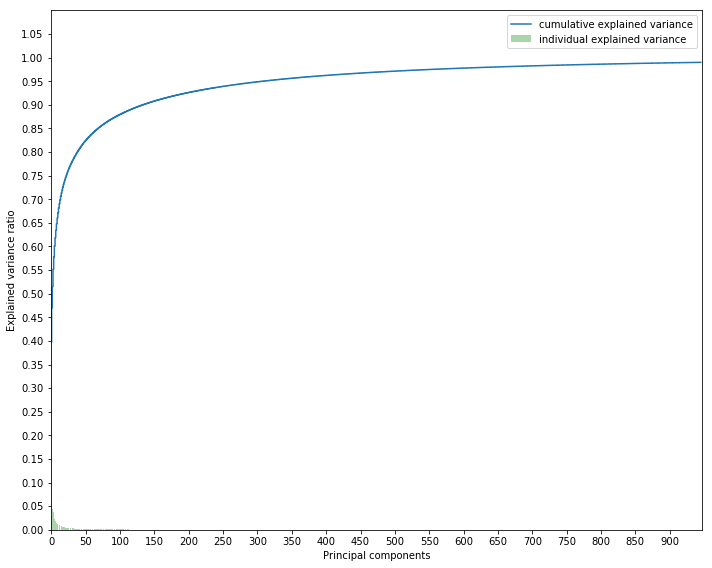

In [9]:
def plot_explained_variance(explained_var, n_components):
    cum_var_exp = np.cumsum(explained_var)
    plt.figure(figsize=(10, 8))
    plt.bar(range(n_components), explained_var, alpha=0.3333, align='center',
            label='individual explained variance', color='g')
    plt.step(range(n_components), cum_var_exp, where='mid', label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.yticks(np.arange(0,1.1, 0.05))
    plt.xlabel('Principal components')
    plt.xticks(np.arange(min(range(n_components)), max(range(n_components))+10, 50.0))
    plt.legend(loc='best')
    plt.tight_layout();plt.xlim((-1, n_components + 1))
    plt.ylim((0, 1.1))
    plt.savefig('./figure/pca_variance_explained.png', bbox_inches='tight')
plot_explained_variance(pca.explained_variance_ratio_, n_components)    

### Reconstruct Images

Reconstruct images based on PCA transformation

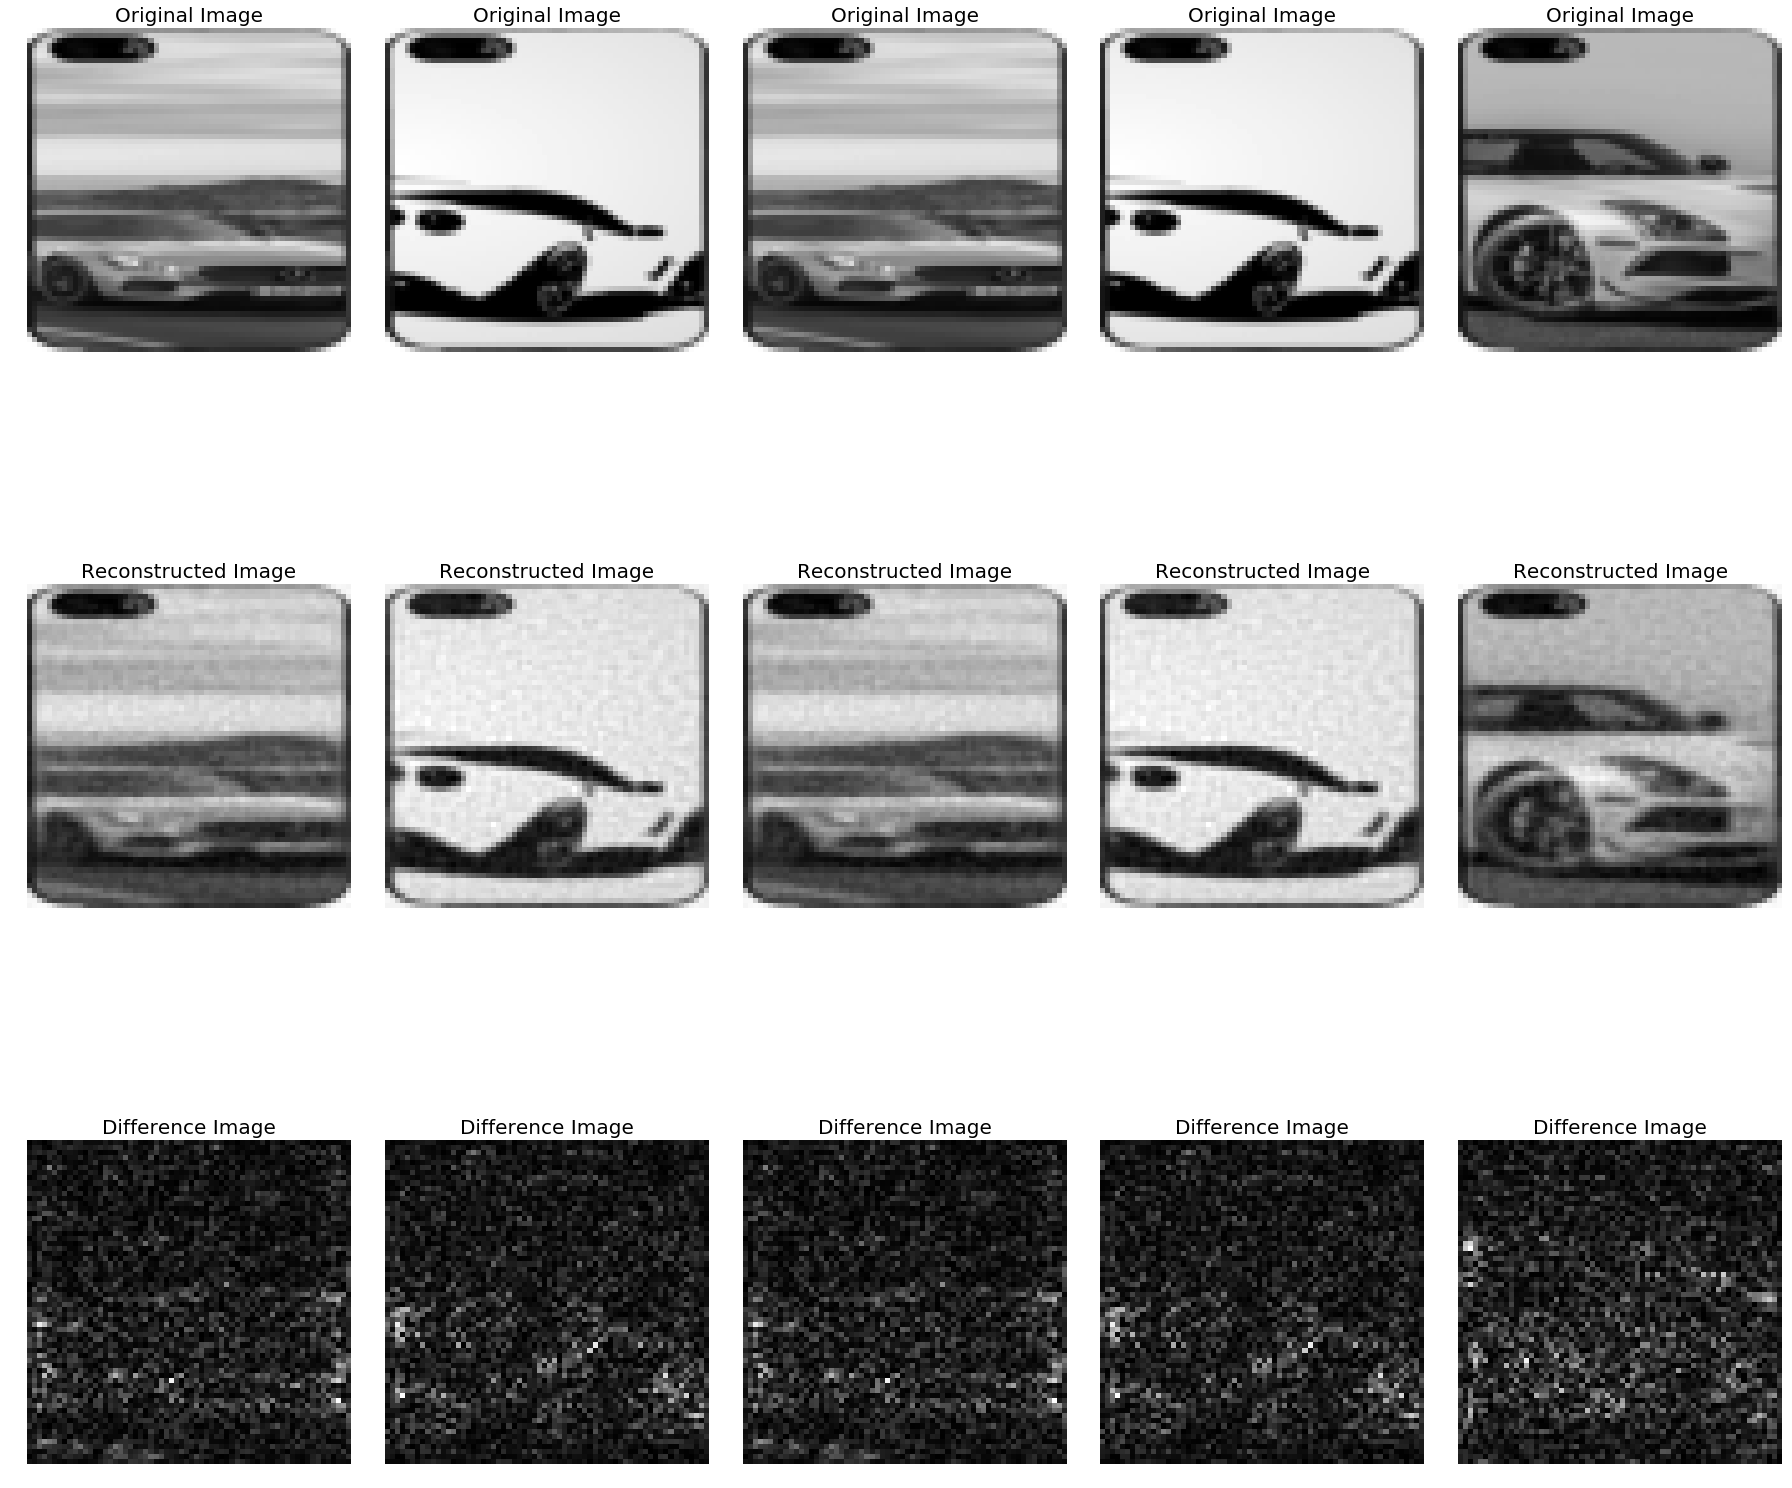

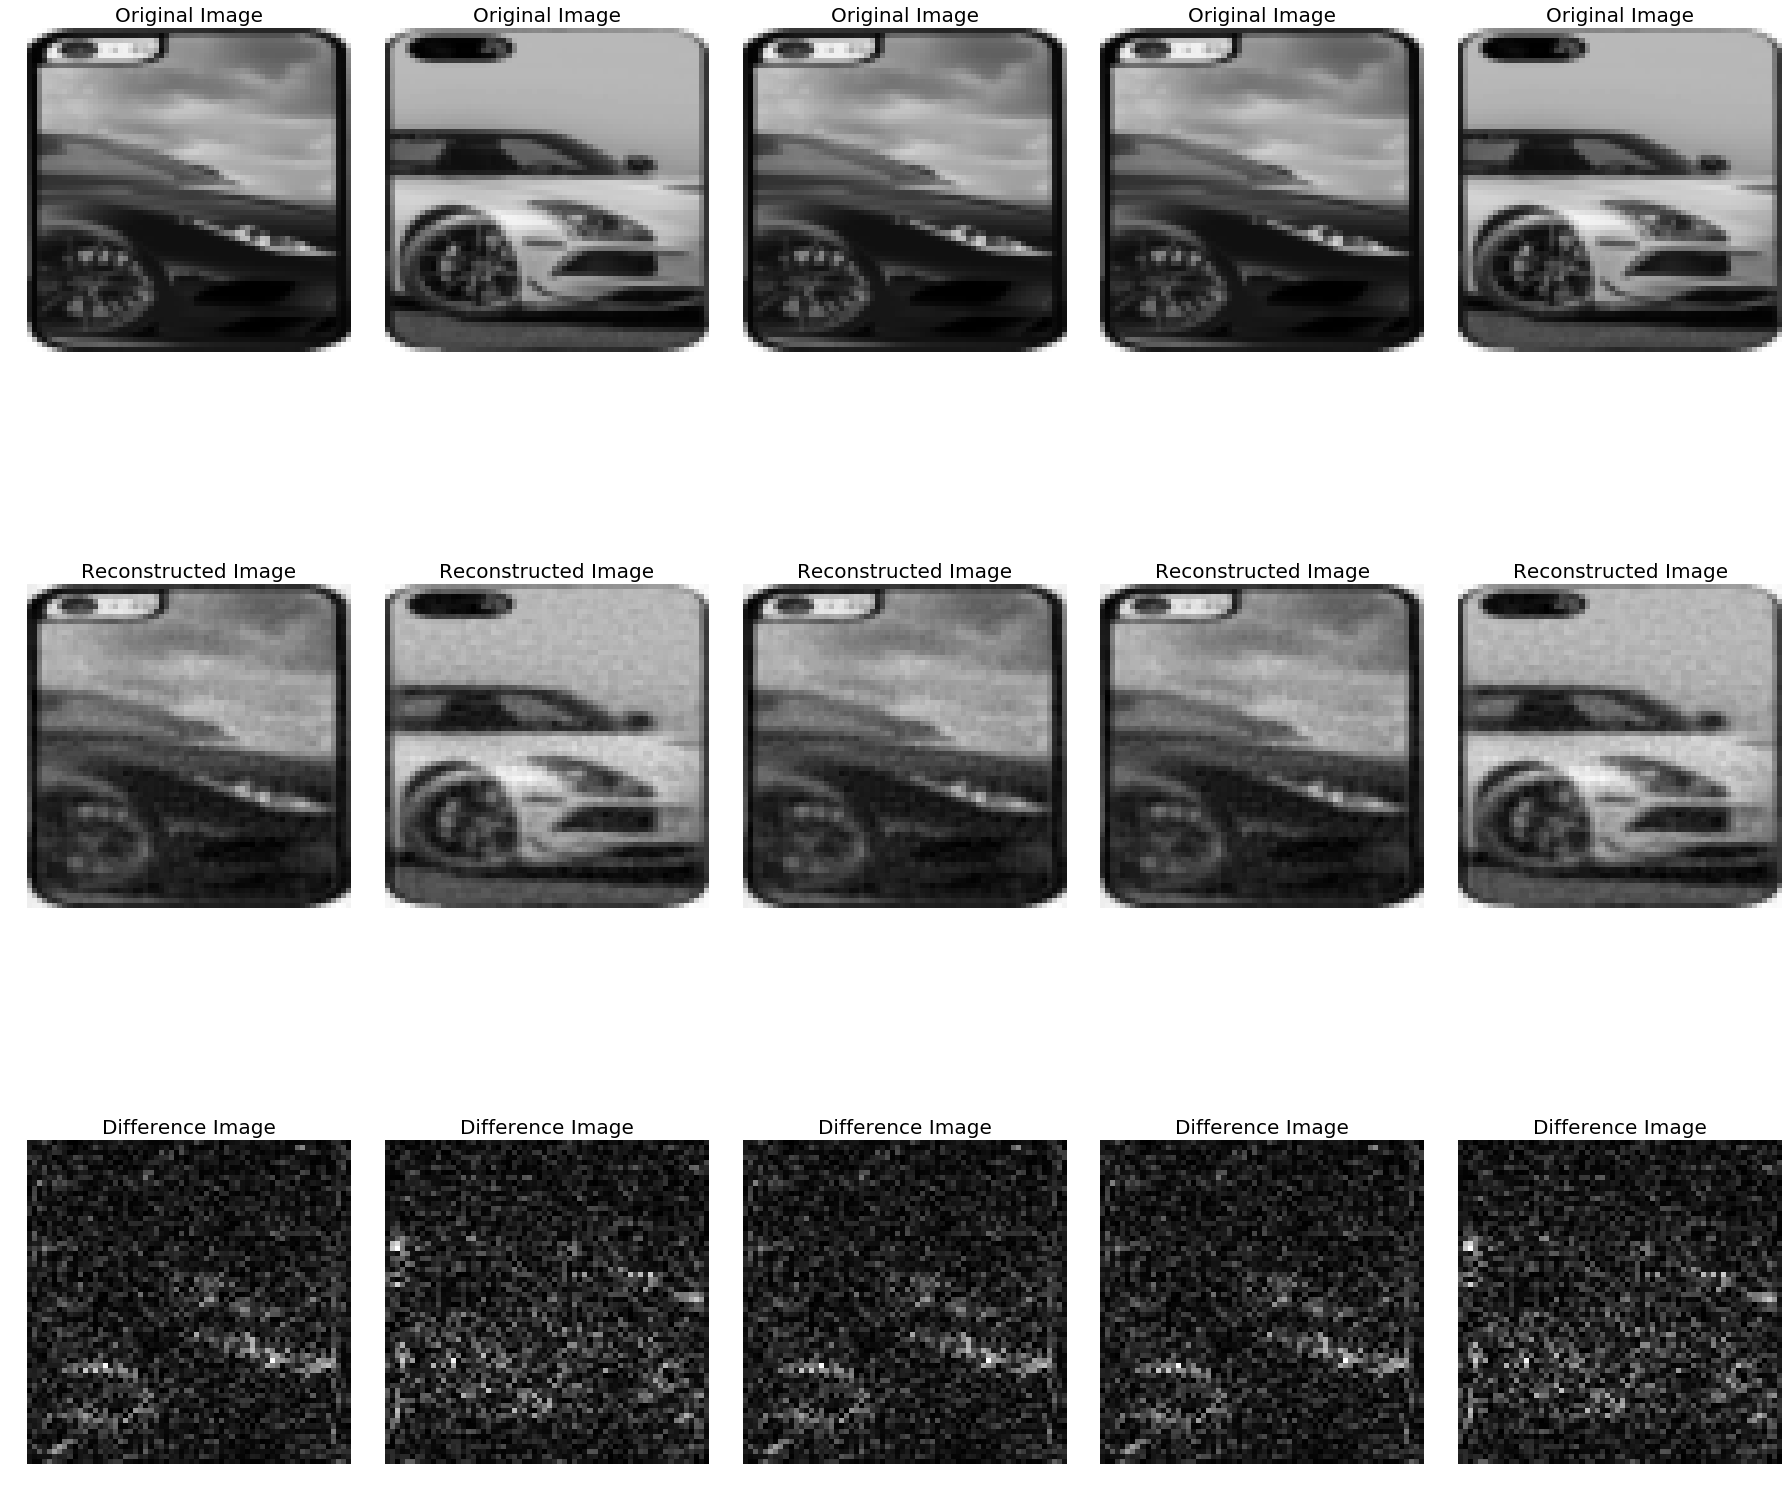

In [10]:
def ReconstructImage(pcamodel, img):
    pca_rep = pcamodel.transform(img)
    rec_img = pcamodel.inverse_transform(pca_rep)
    return rec_img
    
def showReconstructImage(pca, X, numReconstruct = 10):
    np.random.seed(101)
    numSamples = X.shape[0]
    numSamperFig = min(5,numReconstruct)
    numFig = int(np.ceil(numReconstruct/numSamperFig))
    for fig in range(numFig):
        plt.figure(figsize=(25,25))
        for col in range(numSamperFig):
            imgInd = np.random.randint(numSamperFig)
            img = X[imgInd,:].reshape(1,-1) #only 1 sample
            reconstruct_img = ReconstructImage(pca, img)
            diff_img = abs(img - reconstruct_img)
            
            # Plot original image
            plt.subplot(3,numSamperFig,0*numSamperFig+col+1)
            plt.title('Original Image', fontsize=20)
            plt.imshow(img.reshape(h,w),cmap=plt.cm.gray)
            plt.axis('off')
            
            # Plot the reconstructed image
            plt.subplot(3,numSamperFig,1*numSamperFig+col+1)
            plt.title('Reconstructed Image', fontsize=20)
            plt.imshow(reconstruct_img.reshape(h,w),cmap=plt.cm.gray)
            plt.axis('off')
            
            # Plot the difference image
            plt.subplot(3,numSamperFig,2*numSamperFig+col+1)
            plt.title('Difference Image', fontsize=20)
            plt.imshow(diff_img.reshape(h,w),cmap=plt.cm.gray)
            plt.axis('off')
        plt.tight_layout()
showReconstructImage(pca, train_img_flat_norm)

## Logistic Regression

Logistic regression is a probabilistic model that models a binary response variable based on different explanatory variables. It has the following advantages - 

1. Easy model to implement and interpret. The weights help us explain the effect of individual explanatory variables on the response variable.

2. Although it is generally used for binary response variables, it can be extended to multiclass classification using 'one-vs-rest' methodology. In one-vs-all methodology, *K* binary classifiers are built for *K-class* classification. A given sample is assigned to the class for which it has been assigned the maximum probability.

<img src="./figure/ovr_technique.png">

3. Performs well on linearly seperable cases.

### Understanding Logistic Regression

To understand logistic regression, let's start with defining odds ratio.

$$ Odds Ratio = \frac{p}{1-p} $$

where p = the probability of the event of interest. e.g - probability of a patient surviving

Taking the log of the odds ratio, logit(p) is defined as 
$$logit(p) = log{\frac{p}{1-p}}$$

which can be further expressed in linear form as

$$ logit(p(y=1|x)) = w_0x_0 + w_1x_1 + ... + w_mx_m = \sum_{i=1}^{m} {w_ix_i} = W^TX $$

where, 
    - $p(y=1|x)$ = conditional probability of a sample belonging to class 1
    - m = number of samples
    - X = explanatory features
    - W = weights

Using this information, we can now compute $p(y=1|x)$. To compute, we need to compute the inverse of the logit function, which also known as logistic or the sigmoid function. It is defined as follows  

$$ \phi(z) = \frac{1}{1+e^{-z}} $$

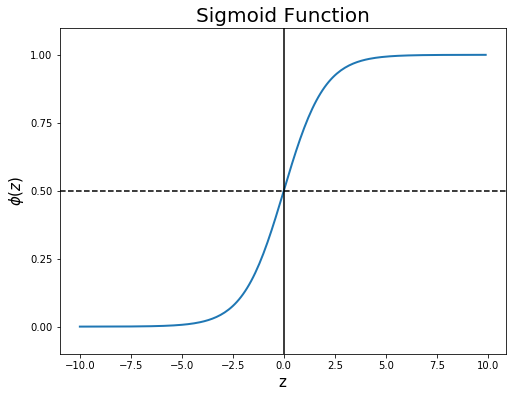

In [33]:
def sigmoid(z):
    return (1.0/(1.0+np.exp(-z)))

def tanh(z):
    return (2 * sigmoid(2 * z)) - 1


def relu(z):
    return np.maximum(z,0)

#Sigmoid
z = np.arange(-10,10,0.1)
phi_z = sigmoid(z)
plt.figure(figsize=(8,6))
plt.plot(z, phi_z,lw=2)

plt.axvline(0.0, color='k')
plt.axhspan(0.0,1.0,facecolor='1.0',alpha=1.0, ls='--')
plt.axhline(y=0.5,ls='--',color='k')
plt.yticks([-1,-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylim(-0.1,1.1)

plt.xlabel('z', fontsize=15)
plt.ylabel('$\phi(z)$', fontsize=15)
plt.title('Sigmoid Function', fontsize=20)

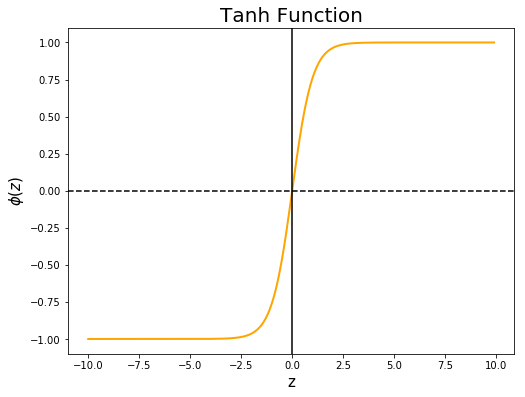

In [34]:
plt.figure(figsize=(8,6))

tanh_z = tanh(z)
plt.plot(z, tanh_z, color='orange',lw=2)


plt.axvline(0.0, color='k')
plt.axhspan(0.0,1.0,facecolor='1.0',alpha=1.0, ls='--')
plt.axhline(y=0.0,ls='--',color='k')
plt.yticks([-1,-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylim(-1.1,1.1)

plt.xlabel('z', fontsize=15)
plt.ylabel('$\phi(z)$', fontsize=15)
plt.title('Tanh Function', fontsize=20)

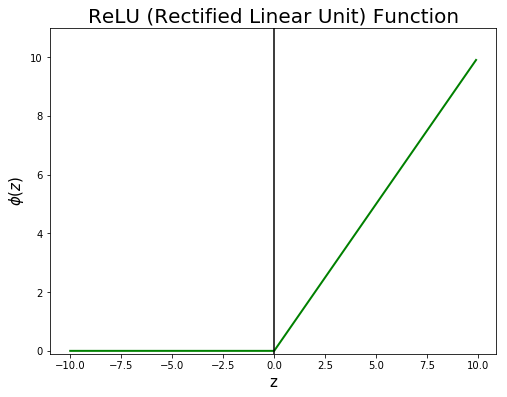

In [35]:
plt.figure(figsize=(8,6))

relu_z = relu(z)
plt.plot(z, relu_z, color='green', lw=2)


plt.axvline(0.0, color='k')
plt.axhspan(0.0,1.0,facecolor='1.0',alpha=1.0, ls='--')
# plt.axhline(y=0.0,ls='--',color='k')
# plt.yticks([-1,-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylim(-0.1,11)

plt.xlabel('z', fontsize=15)
plt.ylabel('$\phi(z)$', fontsize=15)
plt.title('ReLU (Rectified Linear Unit) Function', fontsize=20)

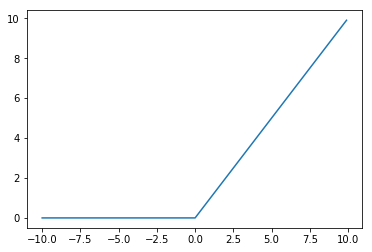

In [17]:
plt.plot(z,relu(z))

From the above plot, we can see that $lim_{z\to\infty} {\phi(z)} = 1$ and $lim_{z\to-\infty} {\phi(z)} = 0$. Hence, the sigmoid function takes real numbers as input and transforms them into the range [0,1] with an intercept at $\phi{z} = 0.5$. This is convenient in terms of modeling probabilities. Hence, the predicted output can be written as,

$\hat{y} = 
\left\{
		\begin{array}{ll}
				1 & \mbox{if } \phi(z) \geq 0.5\\
				0 & \mbox otherwise
		\end{array}
\right.$

or

$\hat{y} = 
\left\{
		\begin{array}{ll}
				1 & \mbox{if } z\geq0\\
				0 & \mbox otherwise
		\end{array}
\right.$

### Training logistic regression

Sum-squared error as the cost function for the model is defined as 

$$ J(w) = \sum_{i} {\frac{1}{2} ({\phi (z^{i}) - y^{i}})^2} $$

We need to maximize the likelihood of sample *x* belonging to class *k*. Therefore,

$$ L(w) = P(y|x;w) = \prod_{i=1}^{N} P(y^{i}|x^{i},w) = \prod_{i=1}^{N} (\phi(z^{i})^{y^{i}}) (1-\phi(z^{i}))^{1-y^{i}}$$

## Fit a Logistic Regression

Multiclass logistic regression on PCA transformed images.

In [35]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Cross-validation strategy: Shuffle and split
cv_ss = ShuffleSplit(n_splits=5, test_size=0.3, random_state=7985)

# Define a scorer
scorer = make_scorer(f1_score, average='weighted')

param_grid = {'C':[1e-6,1e-4,1e-2,0.1, 1, 10, 100, 1000, 10000, 1000000]}
clf = LogisticRegression(fit_intercept=True,class_weight='balanced', #n_samples / (n_classes * np.bincount(y))
                         solver='lbfgs',
                         penalty='l2',
                         max_iter=500,
                         n_jobs=-1,
                         multi_class='ovr',
                         random_state=9)

lr_gridSearchCV = GridSearchCV(estimator=clf,
                              param_grid=param_grid,
                              scoring=scorer,
                              cv=cv_ss)

lr_gridSearchCV.fit(X_train_pca, train_label)

Wall time: 41min 43s


In [25]:
lr_gridSearchCV.best_estimator_

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=9,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [26]:
lr_gridSearchCV.best_score_

0.52078968129084424

Learning curve tells us the performance of the classifier as we increase the training size. The validation score (10% of the full dataset) is computed for different training sizes. The scores are averaged over the cross-validation folds.

In [28]:
scorer = make_scorer(f1_score, average='weighted')

train_sizes, train_scores, val_scores = learning_curve(estimator=lr_gridSearchCV.best_estimator_,
                                                      X=X_train_pca,
                                                      y=train_label,
                                                      train_sizes=np.linspace(0.1,1.0,10),
                                                      cv=cv_ss,
                                                      n_jobs=-1,
                                                      scoring=scorer)

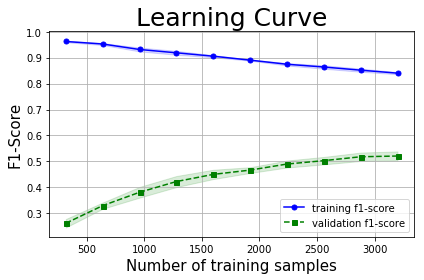

In [29]:
def plot_filled(train_scores,test_scores,train_sizes, xlabel=''):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='training f1-score')

    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation f1-score')

    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('F1-Score', fontsize=15)
    plt.legend(loc='best')
    plt.title('Learning Curve',fontsize=25)
    plt.tight_layout()
plot_filled(train_scores, val_scores, train_sizes, xlabel='Number of training samples')